In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import silhouette_score
from IPython.display import clear_output

# Load the CSV File
file_path = "tournament_decks.csv"
data = pd.read_csv(file_path)
data

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards
0,https://limitlesstcg.com/tournaments/jp/1839,1-3,milotic,farigiraf,https://limitlesstcg.com/decks/list/jp/27337,1,P#Feebas#3#https://limitlesstcg.com/cards/SSP/...
1,https://limitlesstcg.com/tournaments/jp/1839,だいくん。,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27338,2,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
2,https://limitlesstcg.com/tournaments/jp/1839,omochikun,xatu,espathra,https://limitlesstcg.com/decks/list/jp/27339,3,P#Natu#3#https://limitlesstcg.com/cards/PAR/71...
3,https://limitlesstcg.com/tournaments/jp/1839,セラ,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27340,4,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
4,https://limitlesstcg.com/tournaments/jp/1839,伸び代のペリ,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/27341,5,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
...,...,...,...,...,...,...,...
8345,https://limitlesstcg.com/tournaments/jp/2369,ちよっぱ,armarouge,ho-oh,https://limitlesstcg.com/decks/list/jp/35580,12,P#Charcadet#3#https://limitlesstcg.com/cards/S...
8346,https://limitlesstcg.com/tournaments/jp/2369,れつ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/35581,13,P#Charmander#3#https://limitlesstcg.com/cards/...
8347,https://limitlesstcg.com/tournaments/jp/2369,りーとん,flareon,noctowl,https://limitlesstcg.com/decks/list/jp/35582,14,P#Hoothoot#3#https://limitlesstcg.com/cards/SC...
8348,https://limitlesstcg.com/tournaments/jp/2369,たろ,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35583,15,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...


In [2]:
# Parse the "cards" column to extract card links, counts, and types as features
def parse_cards_with_types(cards):
    card_list = cards.split('|')
    card_features = {"p": {}, "t": {}, "e": {}}
    for card in card_list:
        parts = card.split('#')
        if len(parts) >= 3:
            card_type = parts[0].lower() # Extract card type (e.g., "pokemon", "trainer", "energy")
            card_link = parts[3]         # Use the card link as the feature
            card_count = int(parts[2])   # Use the card count as the value
            if card_type in card_features:
                card_features[card_type][card_link] = card_count
    return card_features

card_features_with_types = data['cards'].apply(parse_cards_with_types)
card_features_with_types

0       {'p': {'https://limitlesstcg.com/cards/SSP/41'...
1       {'p': {'https://limitlesstcg.com/cards/TEF/123...
2       {'p': {'https://limitlesstcg.com/cards/PAR/71'...
3       {'p': {'https://limitlesstcg.com/cards/TEF/123...
4       {'p': {'https://limitlesstcg.com/cards/TWM/128...
                              ...                        
8345    {'p': {'https://limitlesstcg.com/cards/SSP/32'...
8346    {'p': {'https://limitlesstcg.com/cards/MEW/4':...
8347    {'p': {'https://limitlesstcg.com/cards/SCR/114...
8348    {'p': {'https://limitlesstcg.com/cards/TWM/128...
8349    {'p': {'https://limitlesstcg.com/cards/SVI/84'...
Name: cards, Length: 8350, dtype: object

In [3]:
# Separate features by card type
pokemon_features = card_features_with_types.apply(lambda x: x['p'])
trainer_features = card_features_with_types.apply(lambda x: x['t'])
energy_features = card_features_with_types.apply(lambda x: x['e'])

# Convert each card type into a feature matrix
vectorizer = DictVectorizer(sparse=True)
pokemon_matrix = vectorizer.fit_transform(pokemon_features)
trainer_matrix = vectorizer.fit_transform(trainer_features)
energy_matrix = vectorizer.fit_transform(energy_features)

# Weight the features by card type (adjust weights as needed)
pokemon_weight = 1.0
trainer_weight = 0.3
energy_weight = 0.1

# Combine the weighted feature matrices
X_combined = hstack([
    pokemon_matrix * pokemon_weight,
    trainer_matrix * trainer_weight,
    energy_matrix * energy_weight
])

# Normalize the combined feature matrix
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_combined)
X_scaled

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 237455 stored elements and shape (8350, 800)>

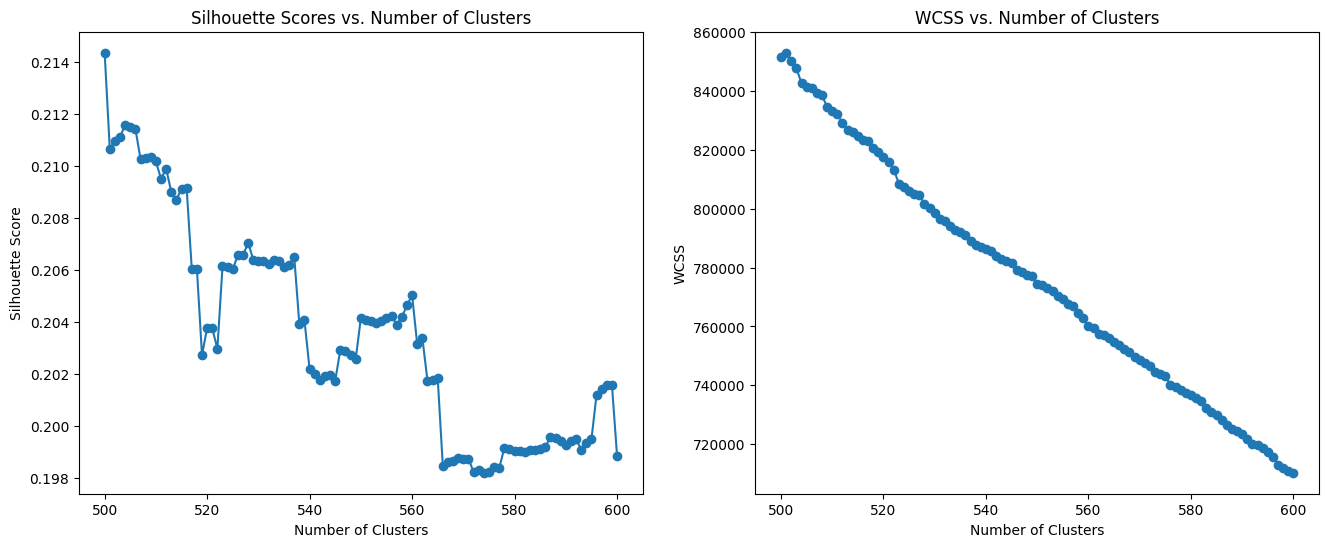

500

In [6]:
# Find the optimal number of clusters
start_clusters = 500
end_clusters = 600
silhouette_scores = []
wcss = []
cluster_range = range(start_clusters, end_clusters + 1)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    wcss.append(kmeans.inertia_)

    if n_clusters % 10 == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot silhouette scores
        axes[0].plot(range(start_clusters, n_clusters + 1), silhouette_scores, marker='o')
        axes[0].set_title('Silhouette Scores vs. Number of Clusters')
        axes[0].set_xlabel('Number of Clusters')
        axes[0].set_ylabel('Silhouette Score')

        # Plot WCSS
        axes[1].plot(range(start_clusters, n_clusters + 1), wcss, marker='o')
        axes[1].set_title('WCSS vs. Number of Clusters')
        axes[1].set_xlabel('Number of Clusters')
        axes[1].set_ylabel('WCSS')

        # Show the plots
        plt.show()

# index of max silhouette score
silhouette_scores.index(max(silhouette_scores)) + start_clusters


In [5]:
num_clusters = 448
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

In [12]:
# Calculate the median rank for each cluster
cluster_summary = data.groupby('cluster').agg(
    mean_rank=('rank', 'mean'),  # Mean rank of decks in each cluster
    median_rank=('rank', 'median'),  # Median rank of decks in each cluster
    cluster_size=('cluster', 'size'), # Number of decks in each cluster
    main_pokemon=('mainpokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common main Pokemon
    secondary_pokemon=('secondarypokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common secondary Pokemon
).reset_index()

# Sort clusters by mean_rank (ascending) to find the best-performing clusters
cluster_summary = cluster_summary.sort_values(by=['mean_rank', 'median_rank'], ascending=[True, True])

# cluster_summary[(cluster_summary['cluster_size'] > 20)].head(20)
# cluster_mean_rank[(cluster_mean_rank['main_pokemon'] == 'charizard') & (cluster_mean_rank['secondary_pokemon'] == 'dudunsparce')].head(20)
cluster_summary[((cluster_summary['main_pokemon'] == 'charizard') | (cluster_summary['secondary_pokemon'] == 'charizard')) & (cluster_summary['cluster_size'] > 10)].head(20)
# cluster_mean_rank[(cluster_mean_rank['cluster'] == 452)].head(20)



,cluster,mean_rank,median_rank,cluster_size,main_pokemon,secondary_pokemon
415,415,7.076923,5.0,13,charizard,pidgeot
395,395,7.629630,7.0,27,charizard,pidgeot
435,435,7.813333,8.0,75,noctowl,charizard
5,5,8.042169,8.0,166,charizard,noctowl
129,129,8.293103,8.0,58,charizard,dudunsparce
84,84,8.777778,9.0,135,dragapult,charizard
73,73,8.933333,10.0,90,charizard,pidgeot
231,231,8.937500,9.5,128,charizard,pidgeot
385,385,9.170455,9.0,88,noctowl,charizard
420,420,10.250000,11.0,24,charizard,pidgeot


In [ ]:
data[data['deckurl'] == "https://limitlesstcg.com/decks/list/jp/34052"]

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
6803,https://limitlesstcg.com/tournaments/jp/2273,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34052,1,P#Charmander#4#https://limitlesstcg.com/cards/...,73


In [17]:
# Sort values by rank then by tournamenturl
data[data['cluster'] == 73].sort_values(by=['rank', 'tournamenturl'], ascending=[True, False])

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
7635,https://limitlesstcg.com/tournaments/jp/2325,レン,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34875,1,P#Charmander#3#https://limitlesstcg.com/cards/...,73
6803,https://limitlesstcg.com/tournaments/jp/2273,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34052,1,P#Charmander#4#https://limitlesstcg.com/cards/...,73
6395,https://limitlesstcg.com/tournaments/jp/2247,えぬえぬ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/33651,1,P#Charmander#3#https://limitlesstcg.com/cards/...,73
5644,https://limitlesstcg.com/tournaments/jp/2198,カネケン,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32907,1,P#Charmander#4#https://limitlesstcg.com/cards/...,73
4602,https://limitlesstcg.com/tournaments/jp/2132,りんぞー,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/31891,1,P#Charmander#3#https://limitlesstcg.com/cards/...,73
...,...,...,...,...,...,...,...,...
6234,https://limitlesstcg.com/tournaments/jp/2234,しゅん,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/33490,16,P#Charmander#2#https://limitlesstcg.com/cards/...,73
6042,https://limitlesstcg.com/tournaments/jp/2222,にゃかむーん,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/33299,16,P#Charmander#3#https://limitlesstcg.com/cards/...,73
5451,https://limitlesstcg.com/tournaments/jp/2185,アキハ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32719,16,P#Charmander#3#https://limitlesstcg.com/cards/...,73
3913,https://limitlesstcg.com/tournaments/jp/2088,オーク,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/31210,16,P#Hoothoot#3#https://limitlesstcg.com/cards/SC...,73


In [16]:
data[data['cluster'] == 452].sort_values(by=['rank', 'cluster'], ascending=[True, False])

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
628,https://limitlesstcg.com/tournaments/jp/1882,ソーダ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/27955,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
2363,https://limitlesstcg.com/tournaments/jp/1991,こあら,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/29673,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
5644,https://limitlesstcg.com/tournaments/jp/2198,カネケン,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32907,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
6395,https://limitlesstcg.com/tournaments/jp/2247,えぬえぬ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/33651,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
6755,https://limitlesstcg.com/tournaments/jp/2270,おおくぼ,charizard,noctowl,https://limitlesstcg.com/decks/list/jp/34005,1,P#Charmander#3#https://limitlesstcg.com/cards/...,452
6803,https://limitlesstcg.com/tournaments/jp/2273,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34052,1,P#Charmander#4#https://limitlesstcg.com/cards/...,452
5034,https://limitlesstcg.com/tournaments/jp/2159,砂,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32315,2,P#Charmander#4#https://limitlesstcg.com/cards/...,452
5725,https://limitlesstcg.com/tournaments/jp/2203,さけ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/32987,2,P#Charmander#3#https://limitlesstcg.com/cards/...,452
7715,https://limitlesstcg.com/tournaments/jp/2330,カッター,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/34954,2,P#Charmander#3#https://limitlesstcg.com/cards/...,452
2093,https://limitlesstcg.com/tournaments/jp/1974,きな粉もちち,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/29404,3,P#Charmander#3#https://limitlesstcg.com/cards/...,452
